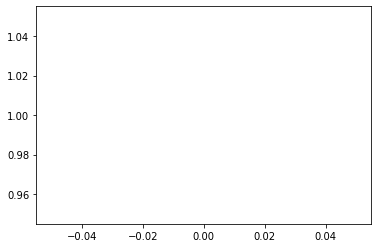

In [1]:
import matplotlib.pyplot as plt
plt.plot([1])

In [2]:

from common import utils
from common.engine import train_one_epoch
from config_rec import all_alph
from MyGenerator.ImageGenerator import ImageGenerator
from util.my_utils import get_array_loss, get_center_loss, get_count_box_loss
from util.my_utils import image_box_show
from MyDataset import MyDataset
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import pil_to_tensor
import cv2
import importlib
import MyModel as my_model
import numpy as np
import os
import PIL
import torch
import torch.utils.data
import torchvision
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint
import torchvision
import torchvision.models.detection as d
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2

to_image = torchvision.transforms.ToPILImage()

configuration = [{ 
    'fonts':['example/TextBPNPlusPlus/dataset/MyGenerator/font.ttf']
    , 'texts':[f'''
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29

               ''']
    , 'text_colors':['#000000']
    , 'size_images':[(500,500)]
    , 'position_texts':[(10,0)]
    , 'font_sizes':[12]
    , 'background_colors':['#ffffff']
    , 'use_box':[False]#not word
    , 'box_colors':['#555555']
    , 'use_lines':['0000']
    , 'lines_colors':['#555555']
    , 'box_colors':['#555555']#not word
}]



#print(conf)
#generator = ImageGenerator(configuration)

#print(f'{generator.size=}')

#img,box,text = generator.get_by_index(0)

num_classes = 2

save_freq = 5
log_folder = 'output/logs/data_f_rcnn_stable_1'
save_dir = 'output/model_1'
save_dir_best = 'output/model_best_1'
save_dir_testing_im = 'output/testing_image_1'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 6

dataset = MyDataset(configuration, is_train=True)

if batch_size> len(dataset):
    batch_size = len(dataset)
    print(f'{batch_size=}')

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)


# get the model using our helper function
model = my_model.get_instance_segmentation_model(num_classes)

#model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=d.MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

# trainable_backbone_layers = None
# rpn_score_thresh = None
# weights=d.MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
# weights_backbone = None
# data_augmentation  = 'hflip'
# kwargs = {"trainable_backbone_layers": trainable_backbone_layers}
# if data_augmentation in ["multiscale", "lsj"]:
#     kwargs["_skip_resize"] = True
# if rpn_score_thresh is not None:
#     kwargs["rpn_score_thresh"] = rpn_score_thresh
# model = maskrcnn_resnet50_fpn_v2(num_classes=num_classes, **kwargs)
#weights=weights, weights_backbone=weights_backbone,


# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

opt_name = 'adamw'
lr =0.005 #0.02
momentum=0.9
weight_decay=0.0005 #1e-4
if opt_name.startswith("sgd"):
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay,
        nesterov="nesterov" in opt_name,
    )
elif opt_name == "adamw":
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)




resalt_metrics = {}
def collback_loss(loss_value, step):
    if 'loss_value' not in resalt_metrics:
        resalt_metrics['loss_value'] = []
    resalt_metrics['loss_value'].append(loss_value)

def convert_for_metrics(batch_size, predicts, targets):
    targets_new = []
    predicts_new = []
    for i in range(batch_size):
        predicts_new.append(
            dict(
                boxes=predicts[i]["boxes"],
                labels=predicts[i]["labels"],
                scores=predicts[i]["scores"],
            )
        )
    
    for i in range(batch_size):
        targets_new.append(
            dict(
                boxes=targets[i]["boxes"],
                labels=targets[i]["labels"],
            )
        )
    return predicts_new,targets_new
    
step = 0

def testing_model(model, data_loader_test):
    metrics = MeanAveragePrecision(box_format="xyxy", class_metrics=False)
    global step, resalt_metrics
    model.eval()    
    losses_array = []
    losses_box = []
    with torch.no_grad():    
        for images, targets in data_loader_test:
            step += 1
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predicts = model(images)
            #print(f'{len(predicts)=}')
            
            
            if 'count_box' not in resalt_metrics:
                resalt_metrics['count_box'] = []                
            
            resalt_metrics['count_box'].append(len(predicts[0]['boxes']))
            
            pred, targ = convert_for_metrics(batch_size,predicts,targets)
            
            metrics.update(pred, targ)
            
            boxes_predict = torch.cat(list(map(lambda m:m["boxes"], predicts)))
            boxes_fact = torch.cat(list(map(lambda m:m["boxes"],targets)))
            
            center_loss = get_center_loss(boxes_predict, boxes_fact)
            
            if center_loss is None:
                center_loss = 1000
            else:
                center_loss = center_loss.item()
                
            if 'center_loss' not in resalt_metrics:
                resalt_metrics['center_loss'] = []                
            resalt_metrics['center_loss'].append(center_loss)
            
            array_loss = get_array_loss(boxes_predict, boxes_fact)            
            
            if array_loss is None:
                array_loss = 1000
            else:
                array_loss = array_loss.item()
                
            if 'array_loss' not in resalt_metrics:
                resalt_metrics['array_loss'] = []                
            resalt_metrics['array_loss'].append(array_loss)
                
            losses_array.append(array_loss)            
            
            len_box_targets = torch.FloatTensor(list(map(lambda m:len(m["boxes"]),targets)))
            len_box_predicts = torch.FloatTensor(list(map(lambda m:len(m["boxes"]),predicts)))
            print(f'{len_box_targets=}')
            print(f'{len_box_predicts=}')
                        
            count_box_loss = get_count_box_loss(len_box_predicts,len_box_targets)
            
            if count_box_loss is None:
                count_box_loss = 1000
            else:
                count_box_loss = count_box_loss.item()
                
            if 'count_box_loss' not in resalt_metrics:
                resalt_metrics['count_box_loss'] = []                
            resalt_metrics['count_box_loss'].append(count_box_loss)
                
            losses_box.append(count_box_loss)            
    
    
    metr = metrics.compute()
    
    if 'map' not in resalt_metrics:
        resalt_metrics['map'] = []
    resalt_metrics['map'].append(metr['map'].item())

    #return resalt_metrics
    
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

min_losses_array,min_losses_box = np.inf,np.inf
num_epochs = 2000

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch,
                    print_freq=10, collback_loss=collback_loss)

    if True or epoch % save_freq == 0 and epoch > 0:
        
        testing_model(model, data_loader)
        
        if resalt_metrics['count_box_loss'][-1] == 0:
            print('count_box_loss == 0 !!!!!!')
            break
        
        #print(f'{losses_array=} {losses_box=}')
        
        #save_testing_images(model, save_dir_testing_im, data_loader_test_im, epoch)

# resalt_metrics = {
#     'm1':[9,7,7,6,5,4,3,2,1],
#     'm2':[9,7,7,6,5,4,3,2,1],
#     'm3':[9,7,7,6,5,4,3,2,1],
#     'm4':[9,7,7,6,5,4,3,2,1]
# }
if resalt_metrics is not None:
    #print(f'{resalt_metrics=}')
    rows = len(resalt_metrics.keys())

    _, axs = plt.subplots(rows,1,figsize=(15,4*rows))
    print(f'{axs}')
    for i,k in enumerate(resalt_metrics):
        axs[i].plot(resalt_metrics[k])
        axs[i].set_title(k)

model.eval()

with torch.no_grad():
    for img,target in dataset:
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        img = img.to(device)
        predicts = model([img])
        boxes = predicts[0]['boxes']
        color = (255,0,0)
        img = img.detach().cpu()
        img = to_image(img)
        for box in boxes:
            p1,p2 = (int(box[0]),int(box[1])),(int(box[2]),int(box[3]))
            img = np.asarray(img)            
            img = cv2.rectangle(img,p1,p2,color,1)
        break

#img = image_box_show(img,box)

plt.figure(figsize=(10,10))
plt.imshow(np.asarray(img))
plt.show()

len(all_alph)=101
['using', 'public', 'null']
all - len(texts)=13924


/home/aleksei/.virtualenvs/ml/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-03-26 10:19:32.082482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 10:19:32.593340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-26 10:19:32.593394: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plu

batch_size=1
Epoch: [0]  [0/1]  eta: 0:00:06  lr: 0.000005  loss: -44.8903 (-44.8903)  loss_classifier: 0.7000 (0.7000)  loss_box_reg: 0.1322 (0.1322)  loss_mask: -46.9835 (-46.9835)  loss_objectness: 0.6940 (0.6940)  loss_rpn_box_reg: 0.5669 (0.5669)  time: 6.3944  data: 5.1132  max mem: 4493
Epoch: [0] Total time: 0:00:06 (6.4271 s / it)
len_box_targets=tensor([464.])
len_box_predicts=tensor([392.])
Epoch: [1]  [0/1]  eta: 0:00:05  lr: 0.000005  loss: -86.4958 (-86.4958)  loss_classifier: 0.6647 (0.6647)  loss_box_reg: 0.0807 (0.0807)  loss_mask: -88.5026 (-88.5026)  loss_objectness: 0.6941 (0.6941)  loss_rpn_box_reg: 0.5671 (0.5671)  time: 5.4879  data: 5.1191  max mem: 5026
Epoch: [1] Total time: 0:00:05 (5.5257 s / it)
len_box_targets=tensor([464.])
len_box_predicts=tensor([500.])
Epoch: [2]  [0/1]  eta: 0:00:05  lr: 0.000005  loss: -124.6458 (-124.6458)  loss_classifier: 0.6341 (0.6341)  loss_box_reg: 0.0544 (0.0544)  loss_mask: -126.5867 (-126.5867)  loss_objectness: 0.6940 (0.6

KeyboardInterrupt: 

In [ ]:
from MyDetection import MyDetection